In [1]:
import numpy as np
import pandas as pd
import geopandas as gd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from shapely.wkt import loads
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

In [2]:
%matplotlib inline

In [3]:
fields = gd.read_file('../outputs/fields_shape.shp')
targets = pd.read_csv('../data/targets.csv', index_col='region', thousands=',')

In [4]:
region_codes = ['KR', 'SE', 'SW']
crs = {'init': 'epsg:3857'}

In [5]:
optimal_tables = [pd.read_csv(f'../outputs/optimal_{region_code}.csv') for region_code in region_codes]
all_optimal = pd.concat(optimal_tables, ignore_index=True, sort=False)
all_optimal['geometry'] = all_optimal['geometry'].apply(loads)
fields_optimal = gd.GeoDataFrame(all_optimal, crs={'init': 'epsg:3857'}, geometry=all_optimal['geometry'])

In [6]:
trials_tables = [pd.read_csv(f'../outputs/trials_{region_code}.csv') for region_code in region_codes]
trials = pd.concat(trials_tables, ignore_index=True, sort=False)

In [7]:
regions = gd.read_file('../spatial/PPIC_Region.shp')

In [8]:
plt.rcParams["figure.figsize"] = (20,10)

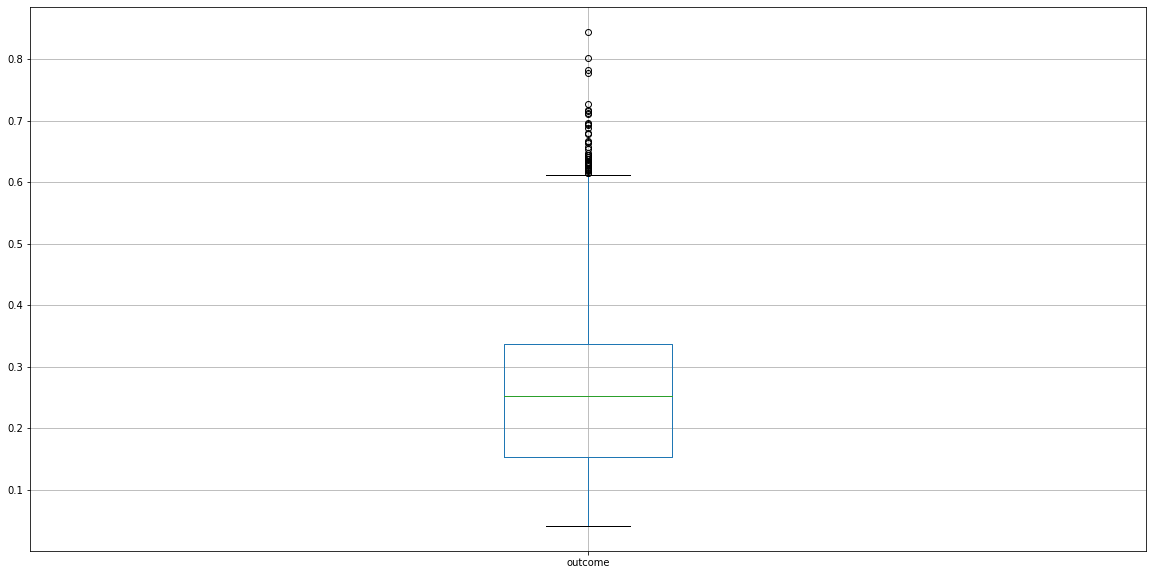

In [9]:
pd.DataFrame(fields_optimal['outcome']).boxplot()

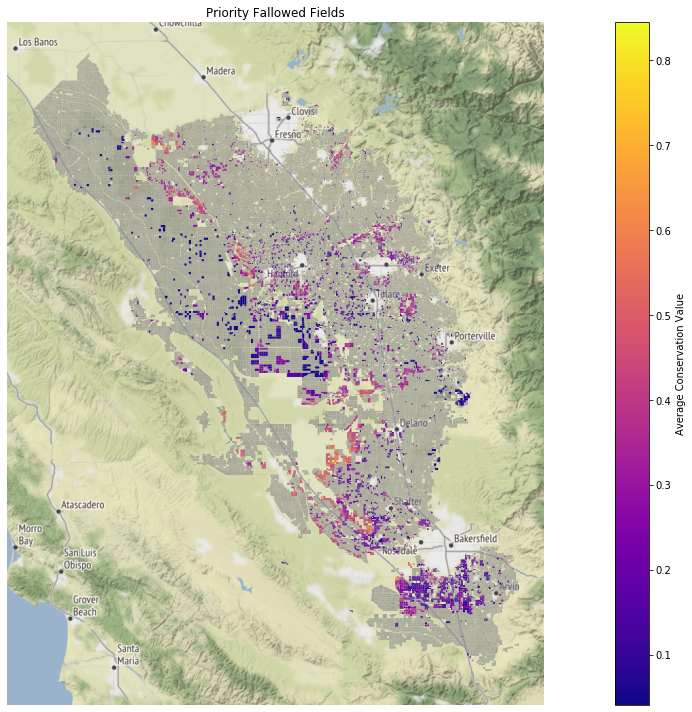

In [10]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
# norm = colors.BoundaryNorm(boundaries=np.array([0,0.01,0.1,1.0]), ncolors=256)
norm = colors.Normalize()

fields.plot(ax=ax, color='grey', alpha=0.6)
fields_optimal.plot(ax=ax, 
                    column='outcome', 
                    norm=norm, 
                    cmap='plasma')
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, reset_extent=True)
ax.set_axis_off()
ax.set_title('Priority Fallowed Fields')

cmap = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
cbar = plt.colorbar(cmap, ax=ax)
cbar.set_label('Average Conservation Value')
plt.tight_layout()
plt.show()

C:\Users\Erik\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


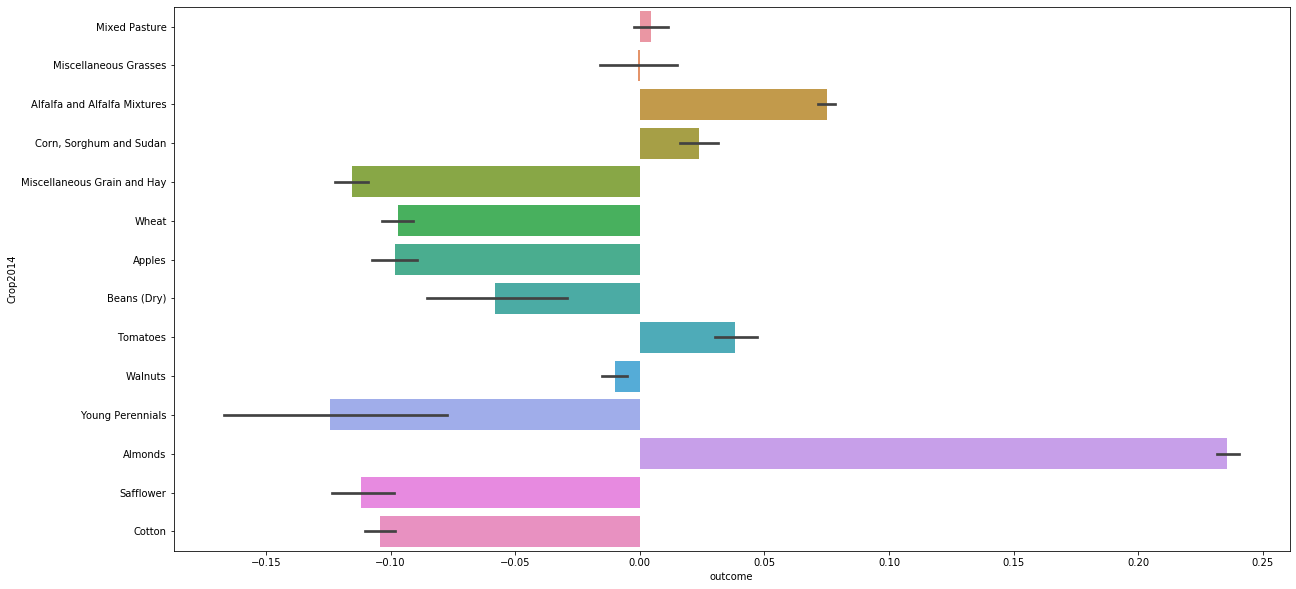

In [11]:
crop_mean_outcome = fields_optimal['outcome'].mean()
sns.barplot(data=fields_optimal, x='outcome', y='Crop2014', estimator = (lambda x: np.mean(x)-crop_mean_outcome), ci=90)

In [12]:
crop_mean_outcome

0.2541270392066206

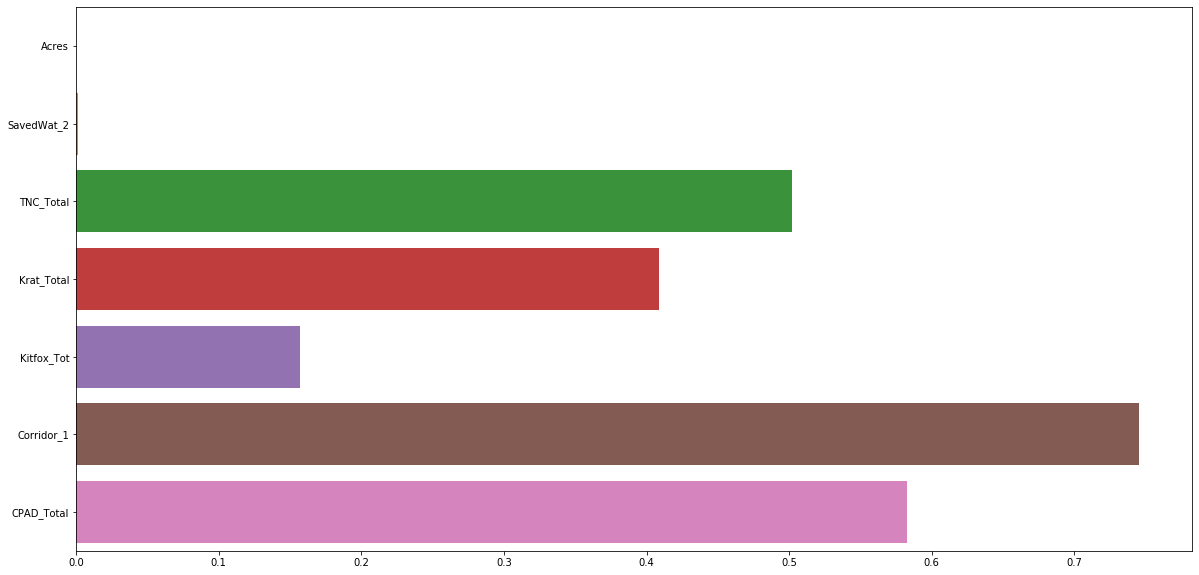

In [13]:
plot_cols = ['Acres', 'SavedWat_2', 'TNC_Total', 'Krat_Total', 'Kitfox_Tot', 'Corridor_1',
            'CPAD_Total']  #Exclude FieldCropPrice and optimal
optimal = fields_optimal[plot_cols].sum()
kern_bau = trials.loc[trials['PPIC_Regio']=='KR',plot_cols].mean()
se_bau = trials.loc[trials['PPIC_Regio']=='SE',plot_cols].mean()
sw_bau = trials.loc[trials['PPIC_Regio']=='SW',plot_cols].mean()
as_usual = kern_bau + se_bau + sw_bau
pct_chg = (optimal - as_usual)/as_usual
sns.barplot(x = pct_chg, y = fields_optimal[plot_cols].columns)

In [14]:
np.sqrt(trials.shape[0])

17.320508075688775

In [15]:
optimal

Acres         385613.010687
SavedWat_2    257608.327347
TNC_Total      49988.921792
Krat_Total      4988.774841
Kitfox_Tot     76187.991431
Corridor_1     44489.850603
CPAD_Total    142023.561344
dtype: float64

In [16]:
as_usual

Acres         385533.855552
SavedWat_2    257350.690221
TNC_Total      33284.017313
Krat_Total      3540.631969
Kitfox_Tot     65851.916945
Corridor_1     25490.539846
CPAD_Total     89751.372584
dtype: float64

In [30]:
optimal - as_usual

Acres            79.155135
SavedWat_2      257.637126
TNC_Total     16704.904479
Krat_Total     1448.142872
Kitfox_Tot    10336.074486
Corridor_1    18999.310757
CPAD_Total    52272.188760
dtype: float64

In [28]:
pct_chg

Acres         0.000205
SavedWat_2    0.001001
TNC_Total     0.501890
Krat_Total    0.409007
Kitfox_Tot    0.156959
Corridor_1    0.745348
CPAD_Total    0.582411
dtype: float64

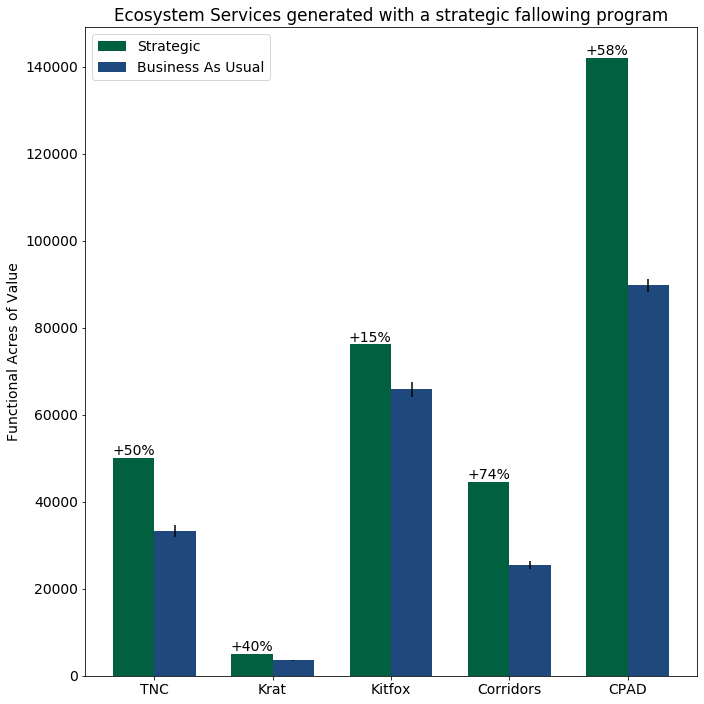

In [17]:
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['font.size'] = 14

N = optimal[2:].shape[0]
width = 0.35
ind = np.arange(N)
as_usual_err = 2.576 * trials[plot_cols].std() / np.sqrt(trials[plot_cols].shape[0])

fig, ax = plt.subplots()
optimal_bars = ax.bar(ind, optimal[2:], width, color='#006040')
as_usual_bars = ax.bar(ind + width, as_usual[2:], width, color='#1F497D', yerr=as_usual_err[2:])

ax.set_title('Ecosystem Services generated with a strategic fallowing program')
ax.set_ylabel('Functional Acres of Value')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('TNC', 'Krat', 'Kitfox', 'Corridors', 'CPAD'))
ax.legend((optimal_bars[0], as_usual_bars[0]), ('Strategic', 'Business As Usual'), loc='upper left')

def autolabel(labels, bars):
    for label, bar in list(zip(labels, bars)):
        height=bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., 
                height,
               f'+{int(label*100)}%',
               ha='center', va='bottom')

autolabel(pct_chg[2:], optimal_bars)
        

plt.tight_layout()
plt.show()

In [18]:
fields_optimal[plot_cols].head()

,Acres,SavedWat_2,TNC_Total,Krat_Total,Kitfox_Tot,Corridor_1,CPAD_Total
0,76.002196,68.315445,74.584828,74.464277,73.571225,0.000000,74.542618
1,49.319529,44.330849,47.877024,31.554011,38.830578,0.000000,47.849929
2,18.954615,17.037428,18.299112,11.343829,13.303835,0.000000,18.288756
3,11.906969,10.702500,11.465059,0.000000,1.130925,11.462519,11.458570
4,33.045659,29.703385,31.927110,4.791743,15.046762,0.000000,31.909041


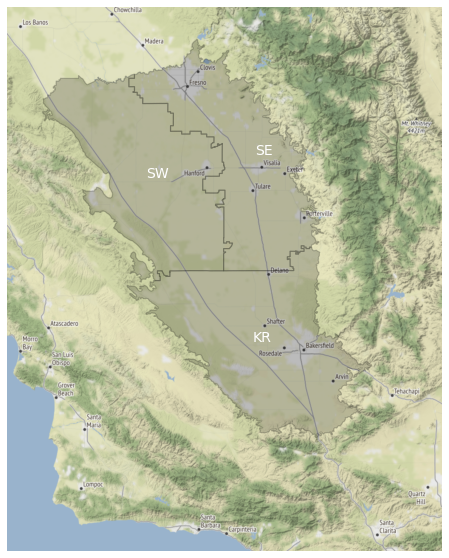

In [19]:
plt.rcParams["figure.figsize"] = (20,10)
regions_to_plot = regions[regions['PPIC_Regio'].isin(region_codes)]
ax = regions_to_plot.plot(linewidth=1.2, edgecolor='k', color='k', alpha=.2)
for idx, row in regions_to_plot.iterrows():
    plt.annotate(s=row['PPIC_Regio'], 
                 xy=tuple([row.geometry.representative_point().x, row.geometry.representative_point().y]),
                ha='center',
                color='w',
                fontsize=14)
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, reset_extent=False)
ax.set_axis_off()

In [20]:
targets[targets.index.isin(region_codes)]

,alfalfa-pasture,corn,field-crops-grains,veg-fruits,trees-vines
region,,,,,
SW,36820.0,3880.0,72350.0,8400.0,7750.0
SE,38760.0,16150.0,124030.0,650.0,9690.0
KR,88500.0,54910.0,42640.0,3230.0,11630.0


In [21]:
targets.index

Index(['NW', 'NE', 'SW', 'SE', 'KR'], dtype='object', name='region')

In [22]:
regions_to_plot.representative_point().y

0    4.220676e+06
3    4.354855e+06
4    4.338451e+06
dtype: float64

In [23]:
fields.columns

Index(['Crop2014', 'Acres', 'FID', 'County', 'PPIC_Regio', 'Crop_PPIC',
       'Price', 'Rotations', 'AdjustedPr', 'FieldCropP', 'WaterConsu',
       'SavedWater', 'TNC', 'Krat', 'Kitfox', 'Corridors', 'CPAD',
       'SavedWat_1', 'TNC_Norm', 'Krat_Norm', 'Kitfox_Nor', 'Corridors_',
       'CPAD_Norm', 'SavedWat_2', 'TNC_Total', 'Krat_Total', 'Kitfox_Tot',
       'Corridor_1', 'CPAD_Total', 'geometry'],
      dtype='object')

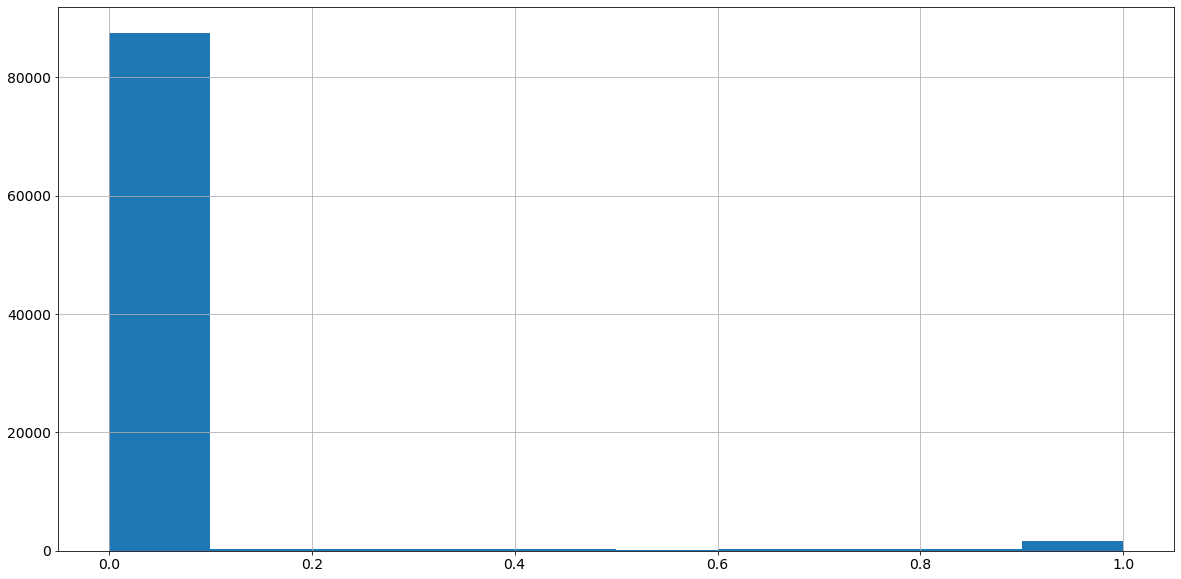

In [24]:
fields['TNC_Norm'].hist()

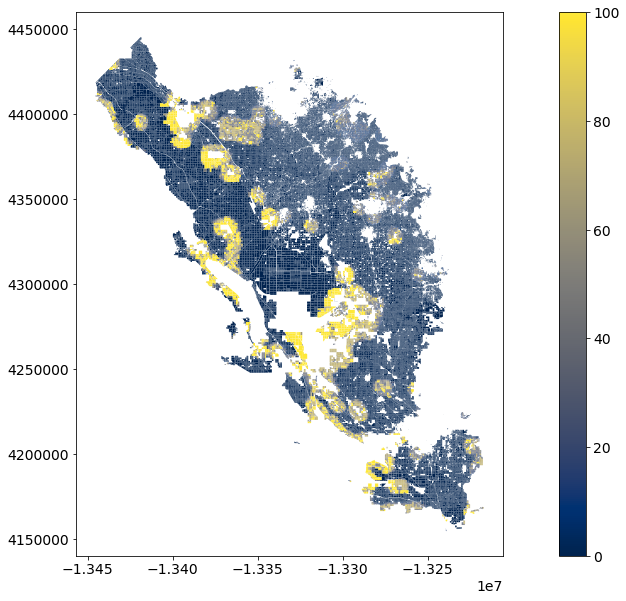

In [33]:
fields.plot(column='CPAD', cmap='cividis', vmin = 0, vmax = 100, legend=True)
#ctx.add_basemap(base, url=ctx.sources.ST_TERRAIN, reset_extent=True)
base.set_axis_off()

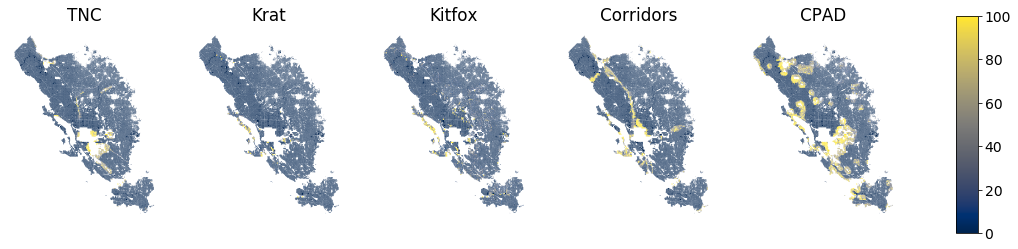

In [34]:
plt.rcParams["figure.figsize"] = (20,10)

eco_services = ['TNC', 'Krat', 'Kitfox', 'Corridors', 'CPAD']

fig, axes = plt.subplots(1,5)
for i in range(5):
    ax = axes[i]
    eco_service = eco_services[i]
    fields.plot(ax=ax, column=eco_service, cmap='plasma', vmin=0, vmax=100, legend=False)
    ax.set_title(eco_service)
    ax.set_axis_off()

cmap = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=100))

## This option provides a slightly smaller CPAD 
# divider = make_axes_locatable(axes[4])
# cax = divider.append_axes("right", size="15%", pad=0.2)
# plt.colorbar(cmap, cax=cax)

# Using the shrink parameter to guess/check an appropriate shrinkage and increase
# the aspect to counteract the shrink 
colorbar = plt.colorbar(cmap, ax=axes, shrink=.4, aspect=10)

plt.show()

In [27]:
eco_services = ['TNC', 'Krat', 'Kitfox', 'Corridors', 'CPAD']
colors=['red', 'olivedrab', 'navy', 'yellow', 'peru']

fig, axes = plt.subplots(1,5)
for i in range(5):
    ax = axes[i]
    eco_service = eco_services[i]
    sns.distplot(fields[fields[eco_service]].dropna()], ax=ax)

SyntaxError: invalid syntax (<ipython-input-27-f87744f518e8>, line 8)